In [224]:
import nltk
import json
import time 
from sklearn import preprocessing as pre
import numpy as np

from nltk.corpus import stopwords

tokenizer = nltk.tokenize.RegexpTokenizer(r"\w+")
import pickle
from scipy.sparse import csr_matrix
from Stemmer import Stemmer
lemmatizer = nltk.stem.WordNetLemmatizer()
import random
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt



In [5]:
stem_dict = dict()
lemmatize_dict = dict()


In [6]:
index_path = "/Users/skosgi/Downloads/nlp/"

infile = open("/Users/skosgi/Downloads/nlp/reviews_Electronics_5.json","r")
index_path = "/Users/skosgi/Downloads/nlp/"


In [7]:
def clean(data):
    punctuations = '0123456789'
    
    d = str.maketrans(dict.fromkeys(punctuations," "))
    data = data.translate(d)
    return data
    

In [10]:
def preprocess(token):
    stemmer = Stemmer('english')
    if token in stem_dict:
        token = stem_dict[token]
    else:
        stem_word = stemmer.stemWord(token)
        stem_dict[token] = stem_word
        token = stem_word
    if token in lemmatize_dict:
        token = lemmatize_dict[token]
    else:
        lem_word = lemmatizer.lemmatize(token)
        lemmatize_dict[token] = lem_word
        token = lem_word
    return token

In [257]:
review_count=10000

In [258]:
t = time.time()
token_set = set()
count = 0;
stop_words = stopwords.words('english')
infile = open("/Users/skosgi/Downloads/nlp/reviews_Electronics_5.json","r")
freq_map = {}
for line in infile:
    count += 1
    if count == review_count:
        break
    jsondict = json.loads(line)
    review_text = clean(jsondict["reviewText"].lower())
    tokens = tokenizer.tokenize(review_text)
    
    for token in tokens:
        if len(token) <=2:
            continue
        token = preprocess(token)
        token_set.add(token)
        if token in freq_map.keys():
            freq_map[token] = freq_map[token]+1
        else:
            freq_map[token] = 1
token_set = list(token_set)
token_set = [k for k in freq_map.keys() if freq_map[k]>=5]        
print("token_set",len(token_set))

infile.close()
enc_map = {}
for i in range(len(token_set)):
    enc_map[token_set[i]] = i
final_list = []
total_prob=0
table_size = 100000000
for key in token_set:
    k = freq_map[key]
    k = np.power(k,0.75)
    total_prob +=k
for key in token_set:
    k = freq_map[key]
    k = np.power(k,0.75)
    pr_k = table_size*k/total_prob
    for i in range(int(pr_k)):
        final_list.append(key)
        
print(time.time()-t)


token_set 4940
15.800692081451416


In [147]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

In [274]:
pickfile = open("dictionary_mappingcbow2","wb")
pickle.dump(enc_map,pickfile)
pickfile.close()

In [260]:

#    lines,dict_count,enc_map=dictionary_count(review_count)
count = 0;
dict_count = len(token_set)
stop_words = stopwords.words('english')
window = 2
infile = open("/Users/skosgi/Downloads/nlp/reviews_Electronics_5.json","r")
t = time.time()
X = []
Y = []
N = []
for line in infile:
    count += 1
    if count == review_count:
        break
    jsondict = json.loads(line)
    review_text = clean(jsondict["reviewText"].lower())
    tokens = tokenizer.tokenize(review_text)
    new_tokens = []
    for token in tokens:
        if len(token) <=2:
            continue    
        token = preprocess(token)
        if(freq_map[token]<5):
            continue
        new_tokens.append(token)
    tokens = [token for token in tokens if token in token_set]
    for i in range(len(tokens)):
        y_index = enc_map[tokens[i]]
        x_context = []
        Neg = []
        j_count = 0
        for j in range(i-window,i+window+1):
            if j!=i and j<len(tokens) and j>=0:
                j_count+=1
                x_index = enc_map[tokens[j]]
                x_context.append(x_index) 
        randnums = random.sample(range(len(final_list)),5)
        for rand in randnums:
            neg_word = final_list[rand]
            neg_index = enc_map[neg_word]
            Neg.append(neg_index)        
        X.append(x_context)
        Y.append(y_index)
        N.append(Neg)    
        if(len(X)%50000==0):
            print("50k samples generated")
infile.close()
print(time.time()-t) 

50k samples generated
50k samples generated
50k samples generated
50k samples generated
50k samples generated
50k samples generated
50k samples generated
50k samples generated
50k samples generated
50k samples generated
50k samples generated
50k samples generated
50k samples generated
54.691683769226074


In [302]:
print(len(X))

669631


In [16]:
def softmax(u):
    exp = np.exp(u-np.max(u))
    exp = exp/exp.sum(axis=0)
    return exp

In [96]:
def forwardProp(x,y,W1,W2):
    h = W1[x]
    u = np.dot(W2.T[y],h)
    y_pred = sigmoid(u)
    return h,u,y_pred

In [255]:
def training(alpha,epochs,encoder_length):
    #print(time.time()-t1)
    t = time.time()
    np.random.seed(3)
    W1 = np.random.uniform(-0.8,0.8,(dict_count,encoder_length))
    W2 = np.random.uniform(-0.8,0.8,(encoder_length,dict_count))
    dw2 = np.zeros(W2.shape)
    dw1 = np.zeros(W1.shape)
    for i in range(epochs):
        loss = 0
        p=0
        for j in range(len(X)):
            if j%100000 ==0:
                print("100k done!")
                #print("t100",time.time()-t)
            p+=1
            t0 = time.time()              
            y = Y[j]
            
            dw2.T[y] = np.zeros(W2.shape[0])
            for n in N[j]:
                dw2.T[n] = np.zeros(W2.shape[0])
            for x in X[j]:
                h,u,y_pred = forwardProp(x,y,W1,W2)
                """if j==3:
                    print("y-pos",y_pred)"""
                loss += -np.log(y_pred)
                dw1[x] = W2.T[y]*(y_pred-1)
                dw2.T[y] = h*(y_pred-1)
                for n in N[j]:
                    h,u,y_pred = forwardProp(x,n,W1,W2)
                    """if j==2:
                        print('y-neg',y_pred)"""
                    loss += -np.log(1-y_pred)
                    dw2.T[n] = h*y_pred
                    dw1[x]+=W2.T[n]*y_pred
                for n in N[j]:
                    W2.T[n] = W2.T[n]-alpha*dw2.T[n]
                #for x in X[j]:
                W1[x] = W1[x]-alpha*dw1[x]
                W2.T[y] = W2.T[y]-alpha*dw2.T[y]
                
            
            #h,u,y_pred = forwardProp1(X[j],y,W1,W2)
        print("No. of iterations:{}, loss:{}".format(i,loss))
        print(time.time()-t)
        if i%20==0:
            pickfile = open("cbow_params2","wb")
            pickle.dump(W1,pickfile)
    print(time.time()-t)    

In [261]:
training(0.01,100,100)    

100k done!
100k done!
100k done!
100k done!
100k done!
100k done!
100k done!
No. of iterations:0, loss:6257546.9987917375
312.32560992240906
100k done!
100k done!
100k done!
100k done!
100k done!
100k done!
100k done!
No. of iterations:1, loss:5344139.6139252735
617.6572530269623
100k done!
100k done!
100k done!
100k done!
100k done!
100k done!
100k done!
No. of iterations:2, loss:5239643.467464705
921.1434919834137
100k done!
100k done!
100k done!
100k done!
100k done!
100k done!
100k done!
No. of iterations:3, loss:5185793.02661498
1226.4983789920807
100k done!
100k done!
100k done!
100k done!
100k done!
100k done!
100k done!
No. of iterations:4, loss:5149412.501605867
1537.849436044693
100k done!
100k done!
100k done!
100k done!
100k done!
100k done!
100k done!
No. of iterations:5, loss:5121833.328066674
1846.61692404747
100k done!
100k done!
100k done!
100k done!
100k done!
100k done!
100k done!
No. of iterations:6, loss:5099651.6825422915
2152.947199821472
100k done!
100k done!
10

100k done!
No. of iterations:58, loss:4892166.691969552
18027.706681013107
100k done!
100k done!
100k done!
100k done!
100k done!
100k done!
100k done!
No. of iterations:59, loss:4891345.690138559
18330.012058019638
100k done!
100k done!
100k done!
100k done!
100k done!
100k done!
100k done!
No. of iterations:60, loss:4890550.683662287
18630.84566807747
100k done!
100k done!
100k done!
100k done!
100k done!
100k done!
100k done!
No. of iterations:61, loss:4889780.6105043525
18915.839801073074
100k done!
100k done!
100k done!
100k done!
100k done!
100k done!
100k done!
No. of iterations:62, loss:4889034.468973992
19189.18202996254
100k done!
100k done!
100k done!
100k done!
100k done!
100k done!
100k done!
No. of iterations:63, loss:4888311.313351076
19460.67697906494
100k done!
100k done!
100k done!
100k done!
100k done!
100k done!
100k done!
No. of iterations:64, loss:4887610.2498778645
19732.2499229908
100k done!
100k done!
100k done!
100k done!
100k done!
100k done!
100k done!
No. o

In [304]:
def similar_words(word,count):
    pickfile = open("cbow_params2","rb")
    w1 = pickle.load(pickfile)
    wfile = open("dictionary_mappingcbow2","rb")
    enc_map = pickle.load(wfile)
    word_vec = w1[enc_map[preprocess(word)]]
    similarity = {}
    for i in range(len(token_set)):
        new_vec = w1[i]
        dot = np.dot(word_vec,new_vec)
        magnitude = np.linalg.norm(new_vec)*np.linalg.norm(word_vec)
        cosine_similarity = dot/magnitude
        similarity[token_set[i]] = cosine_similarity
     
    similarity = sorted(similarity.items(),reverse=True,key = lambda similarity: (similarity[1],similarity[0]))
    k =0
    for wr,score in similarity:
        if k==count:
            break
        print(wr,score)
        k+=1
        

In [305]:
def vector(word):
    pickfile = open("cbow_params2","rb")
    w1 = pickle.load(pickfile)
    return w1[enc_map[preprocess(word)]]    

In [264]:
vector("camera")

array([ 0.56965817, -0.68923911, -0.07708748,  0.25430846, -0.24154785,
       -0.32172032,  0.22234619,  0.18904221,  0.44582496, -0.3025719 ,
       -0.09298468, -0.29569578,  0.00867256, -0.22201751,  0.33997284,
       -0.00930321, -0.22976571,  0.10554939, -0.35347581, -0.47479989,
       -0.04603544,  0.52908996,  0.09820222, -0.20609834,  0.16607627,
        0.06577984, -0.38663827,  0.39753055, -0.05377952, -0.29252249,
       -0.458012  ,  0.19379599, -0.2812052 , -0.06976458, -0.00161043,
        0.35926332, -0.07465457,  0.05603717, -0.25507639,  0.5304703 ,
       -0.2503371 , -0.03168021,  0.18566935,  0.09794058,  0.76716876,
       -0.10367375, -0.00169255,  0.13316833, -0.07537091, -0.05651939,
       -0.20986527, -0.19494251, -0.09643766, -0.14612999, -0.4665728 ,
       -0.05498664,  0.00281619, -0.31700697,  0.14444375,  0.42251368,
        0.0986112 , -0.0231583 ,  0.0492561 ,  0.13306395,  0.24187035,
       -0.36717307, -0.23710812, -0.35050261, -0.32852597,  0.09

In [316]:
print("Similar words for camera on cbow word2vec model using Negative Sampling:")
similar_words('camera',10)

Similar words for camera on cbow word2vec model using Negative Sampling:
camera 0.9999999999999998
lens 0.6273957009136747
it 0.5681831121263408
unit 0.5595687826141541
bag 0.5501650264361143
one 0.5443173787403878
flash 0.5352900862181103
case 0.5342557273531074
canon 0.526708159117382
and 0.5157509624206492


In [297]:
def similar_vectors(word,count):
    pickfile = open("cbow_params2","rb")
    w1 = pickle.load(pickfile)
    wfile = open("dictionary_mappingcbow2","rb")
    enc_map = pickle.load(wfile)
    word_vec = w1[enc_map[preprocess(word)]]
    similarity = {}
    for i in range(len(token_set)):
        new_vec = w1[i]
        dot = np.dot(word_vec,new_vec)
        magnitude = np.linalg.norm(new_vec)*np.linalg.norm(word_vec)
        cosine_similarity = dot/magnitude
        similarity[token_set[i]] = cosine_similarity
     
    similarity = sorted(similarity.items(),reverse=True,key = lambda similarity: (similarity[1],similarity[0]))
    k =0
    sim_vector = []
    print("--------Similar words for the word {}--------".format(word))
    for wr,score in similarity:
        if k==count:
            break
        sim_vector.append(enc_map[wr])
        print(wr)
        k+=1
    return sim_vector 

In [286]:
pickfile = open("cbow_params2","rb")
w1 = pickle.load(pickfile)
embedding = TSNE(n_components=2).fit_transform(w1)
print(embedding)

[[ 0.81466395 -0.41194016]
 [-1.9940114  -1.8812935 ]
 [ 0.89110506  2.12647   ]
 ...
 [ 0.78499824  2.8141003 ]
 [ 1.1828004   0.4505266 ]
 [-0.01278617 -2.850783  ]]


In [319]:
def load_model():
    pickfile = open("cbow_params2","rb")
    w1 = pickle.load(pickfile)
    wfile = open("dictionary_mappingcbow2","rb")
    dict_map = pickle.load(wfile)
    pickfile.close()
    wfile.close()
    model = {}
    for key in dict_map.keys():
        model[key] = w1[key]
    return model

In [294]:
def sim_embeddings(word,count):
    sim_vectors = similar_vectors(word,count)
    x = [embedding[i][0] for i in sim_vectors]
    y = [embedding[i][1] for i in sim_vectors]
    return x,y

--------Similar words for the word music--------
music
listen
bass
guitar
ipod
sound
loud
audio
enjoy
hear
--------Similar words for the word noise--------
nois
elph
quieter
headach
our
mundan
pul
grasp
daili
jpeg
--------Similar words for the word seeing--------
see
find
read
guess
know
tell
hear
get
say
look
--------Similar words for the word good--------
good
great
nice
decent
perfect
cheap
best
sharp
poor
well
--------Similar words for the word review--------
review
product
here
read
item
about
nook
model
three
amazon


Text(0.5, 1.0, 'Word vectors of words using cbow model')

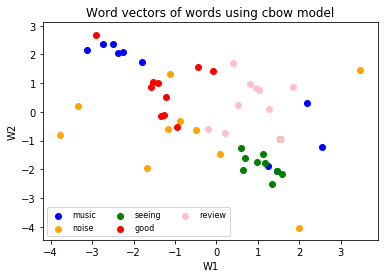

In [317]:
x,y = sim_embeddings("music",10)
x1,y1 = sim_embeddings("noise",10)
x2,y2 = sim_embeddings("seeing",10)
x3,y3 = sim_embeddings("good",10)
x4,y4 = sim_embeddings("review",10)
xy = plt.scatter(x,y,color = "blue")
x1y1 = plt.scatter(x1,y1,color="orange")
x2y2 = plt.scatter(x2,y2,color="green")
x3y3 = plt.scatter(x3,y3,color="red")
x4y4 = plt.scatter(x4,y4,color="pink")


plt.xlabel("W1")
plt.ylabel("W2")
plt.legend((xy, x1y1, x2y2, x3y3, x4y4),
           ('music', 'noise', 'seeing', 'good', 'review'),
           scatterpoints=1,
           loc='lower left',
           ncol=3,
           fontsize=8)
plt.title("Word vectors of words using cbow model")

In [308]:
from gensim.models import Word2Vec,KeyedVectors
import nltk

In [311]:
model = KeyedVectors.load_word2vec_format('/Users/skosgi/Downloads/GoogleNews-vectors-negative300.bin',binary=True,limit = 100000)

In [314]:
print("Similar words for camers on gensim word2vec model using googleNews data")
model.most_similar("camera")

Similar words for camers on gensim word2vec model using googleNews data


[('cameras', 0.8131939172744751),
 ('camera_lens', 0.7250816822052002),
 ('camcorder', 0.7037475109100342),
 ('Camera', 0.6848659515380859),
 ('Cameras', 0.6350969076156616),
 ('tripod', 0.618983805179596),
 ('viewfinder', 0.596660852432251),
 ('webcam', 0.5858357548713684),
 ('Webcam', 0.5843442678451538),
 ('digital_cameras', 0.584299623966217)]